# Desarrollo proyecto Sistemas inteligentes
## Perfil de Consumidor

P2-PerfilCons
Integrantes: Michelle Soto Florido, Andrés Parra Rodríguez, Julio Alberto Parra Martínez, Carlos A. Talero Jacome

En este se describe el desarrollo del modelo de una red neuronal para identificar los posibles tipos de productos a comprar de un cliente en una página de internet. Esto se realizó con la base de datos Customer
Personality Analysis de la página de internet Kaggle.

### 1. Lectura base de datos

Se realiza lectura de la base de datos directamente del archivo descargado. Luego se eliminan variables que no contienen información (Z_CostContact y Z_Revenue) y las que no se emplearán para el modelo (ID y Complain)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random

# Lectura datos
data = pd.read_csv("Customer Personality Analysis.csv",sep='\t')
# Eliminacion de variables no usadas
data.drop(['ID','Z_CostContact', 'Z_Revenue','Dt_Customer','Complain'], axis=1, inplace=True)
# Eliminacion de datos NaN
data = data.dropna()
data.reset_index(drop=True, inplace=True)

### 2. Transformación de las salidas
El propósito de este modelo es predecir con datos demográficos y de comportamiento qué artículos es más probable que compren los usuarios de la plataforma. Las salidas del sistema es un conjunto de datos binarios, donde cada dígito indica la probabilidad de que el usuario puede comprar el artículo o no.

Para esto se hace una frontera con la mediana de cada variable.

Mediana de Wines = 174.5
Media de Wines = 305.09160649819495
Mediana de Fruits = 8.0
Media de Fruits = 26.356046931407942
Mediana de Meats = 68.0
Media de Meats = 166.99593862815885


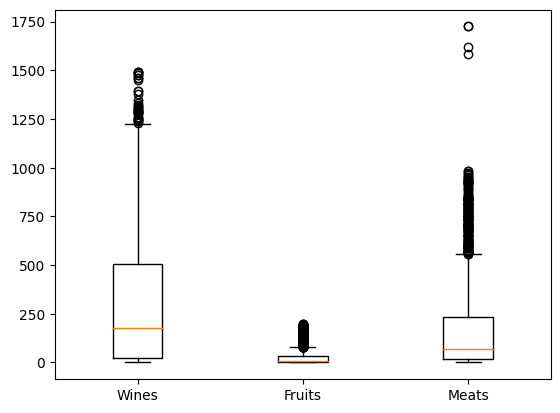

In [ ]:
# Sustrae los targets
targets = data.loc[:, ["MntWines","MntFruits","MntMeatProducts"]]
data.drop(["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"], axis=1, inplace=True)

# Transformacion de la salidas (6) Escoge las menores de la mitad de los datos (menores a mediana) con Normalizacion (z-score)
scalert = StandardScaler()
labels = pd.DataFrame(scalert.fit_transform(targets))
for i in range(targets.shape[1]):
    labels[i] = targets.iloc[:,i] >= np.median(targets.iloc[:,i])
labels = labels.replace({False: 0, True: 1})

# Frontera de desición mediana para binarizar targets
tarNames = ['Wines','Fruits','Meats']
for i in range(targets.shape[1]):
    print('Mediana de ' + tarNames[i] + ' = ' + str(np.median(targets.iloc[:,i])))
    print('Media de ' + tarNames[i] + ' = ' + str(np.mean(targets.iloc[:,i])))

# Boxplot de targets sin normalizar
plt.boxplot(targets,labels=tarNames);

3. Transformaciones a datos de entrada

Se toquenizó en número dos variables que venían como texto (Education y Marital_Status). Se generaron dos nuevas variables que dan información sobre el total de compras y el total de promociones acptadas por cada persona. Finalmente se realizó una estandarización con Z-Score

In [ ]:
# Strings a numeros (Tokenizacion)
label_encoder = LabelEncoder()
data['Education'] = label_encoder.fit_transform(data.loc[:,['Education']])
data['Marital_Status'] = label_encoder.fit_transform(data.loc[:,['Marital_Status']])

# Transformacion logaritmica a datos sesgados a la derecha
# data[] = np.log(data['Income'], 10)

# Nuevas variables
# Total promociones aceptadas
data['Total promociones'] = data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']+data['AcceptedCmp1']+data['AcceptedCmp2']+data['Response']
# Total compras realizadas
data['Total Compras'] = data['NumDealsPurchases']+data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']

# Normalizacion a todas (z-score)
scaler = StandardScaler()
data = scaler.fit_transform(data)

4. Separación entre conjuntos de entrenamiento, test y validación.

Se separaron las observaciones en tres conjuntos de datos:
entrenamiento: 60%
test: 40%
validación 10%

In [ ]:
# Separacion entre datos entrenamiento, prueba y validación.
seed = 50
# Division de conjuntos de entrenamiento (60%) y los otros
X_train, X_temp = train_test_split(data, test_size=0.4, random_state=seed)
# Divicion entre datos de validacion (10%) y test (30%)
X_test, X_vali = train_test_split(X_temp, test_size=0.25, random_state=seed)

# Division de conjuntos de entrenamiento (60%) y los otros
y_train, y_temp = train_test_split(labels, test_size=0.4, random_state=seed)
# Divicion entre datos de validacion (10%) y test (30%)
y_test, y_vali = train_test_split(y_temp, test_size=0.25, random_state=seed)


5. Entrenamiento del modelo

Se empleó una red neuronal clásica con dos capas ocultas, cada una con 128 neuronas. Como función de activación se empleó ReLU (Rectified Linear Unit).

In [86]:
# Red Neuronal con sus parametros
model = MLPClassifier(hidden_layer_sizes=(29, 29), activation='logistic', max_iter=1000, random_state=42)

# Entrena el modelo
model.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(29, 29), max_iter=1000,
              random_state=42)

6. Evaluación del modelo con datos de test

In [87]:
# Test del model
test_accuracy = model.score(X_test, y_test)
print(f'Exactitud datos test: {test_accuracy:,.2f}')
print(" ")

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Funcion m.confunsion
def confu(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    exactitud = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    especificidad = TN / (TN + FP)
    sensibilidad = TP / (TP + FN)
    print(confusion)
    print(f"Exactitud = {exactitud:,.2f}")
    print(f"Precisión = {precision:,.2f}")
    print(f"Especificidad = {especificidad:,.2f}")
    print(f"Sensibilidad = {sensibilidad:,.2f}")


# Calcular la matrices de confusión
tarNames = ['Wines','Fruits','Meats']
print('Predicciones con datos de test')
for i in range(targets.shape[1]):
    print(tarNames[i])
    confu(y_test.iloc[:,i], y_pred[:,i])
    print(' ')

Exactitud datos test: 0.71
 
Predicciones con datos de test
Wines
[[312  32]
 [  9 312]]
Exactitud = 0.94
Precisión = 0.91
Especificidad = 0.91
Sensibilidad = 0.97
 
Fruits
[[267  60]
 [ 64 274]]
Exactitud = 0.81
Precisión = 0.82
Especificidad = 0.82
Sensibilidad = 0.81
 
Meats
[[311  33]
 [ 31 290]]
Exactitud = 0.90
Precisión = 0.90
Especificidad = 0.90
Sensibilidad = 0.90
 


7. Evaluación del modelo con datos de validación

In [88]:
# Exactitud del modelo con conjunto de validación
test_accuracy = model.score(X_vali, y_vali)
print(f"Exactitud datos validación: {test_accuracy:,.2f}")
print(" ")

# Predicciones en el conjunto de validación
y_pred2 = model.predict(X_vali)

# Calcular la matrices de confusión
tarNames = ['Wines','Fruits','Meats']
print('Predicciones con datos de validacion')
for i in range(targets.shape[1]):
    print(tarNames[i])
    confu(y_vali.iloc[:,i], y_pred2[:,i])
    print(' ')

Exactitud datos validación: 0.69
 
Predicciones con datos de validacion
Wines
[[ 98  11]
 [  5 108]]
Exactitud = 0.93
Precisión = 0.91
Especificidad = 0.90
Sensibilidad = 0.96
 
Fruits
[[85 23]
 [24 90]]
Exactitud = 0.79
Precisión = 0.80
Especificidad = 0.79
Sensibilidad = 0.79
 
Meats
[[ 94   6]
 [ 14 108]]
Exactitud = 0.91
Precisión = 0.95
Especificidad = 0.94
Sensibilidad = 0.89
 


## 7. Algoritmo genetico
Luego de obtener los primeros resultados de clasificación, se siguió a optimizar los parámetros de la RN con un algorítmo genético


In [ ]:
def foo(X_train, y_train, X_test, y_test, act, nn1, nn2):
    # Selección de función de activación
    if act == 0:
        ac = 'identity'
    elif act == 1:
        ac = 'logistic'
    elif act == 2:
        ac = 'tanh'
    elif act == 3:
        ac = 'relu'
    else:
        ac = 'logistic'
    # Por si el numero de neuronas muta a un numero menor a 1
    if nn1<1:
        nn1=1
    if nn2<1:
        nn2=1

    # Red Neuronal con sus parametros
    model = MLPClassifier(hidden_layer_sizes=(nn1, nn2), activation=ac, max_iter=1000, alpha=0.1, random_state=42);
    # Entrena el modelo
    model.fit(X_train, y_train)

    # Exactitud del modelo
    test_accuracy = model.score(X_test, y_test)
    return test_accuracy

# Función fitness
def fitness(X_train, y_train,X_test, y_test, act, nn1, nn2):
    ans = foo(X_train, y_train,X_test, y_test, act, nn1, nn2)
    esperado = 0.85
    error = esperado - ans
    return abs(1/error)

# Funcion para imprimir qué parametros evaluó
def paramet(act, nn1, nn2):
    if act == 0:
        ac = 'identity'
    elif act == 1:
        ac = 'logistic'
    elif act == 2:
        ac = 'tanh'
    elif act == 3:
        ac = 'relu'
    else:
        ac = 'logistic'
    print(f" === Activacion {ac} con {nn1} y {nn2} === ")

Corrido del algorítmo genético

In [72]:
# Población inicial (Generación 0)
solutions = []
for s in range(10):
    solutions.append((random.randint(0,4),
                      random.randint(100,150),
                      random.randint(100,150)))


import warnings
# Suprimir las advertencias de convergencia
warnings.filterwarnings("ignore", category=UserWarning)

for i in range(6):
    # Evalua conjunto de soluciones
    rankedsolutions = []
    for s in solutions:
        rankedsolutions.append((fitness(X_train, y_train,X_test, y_test, s[0],s[1],s[2]),s))
    rankedsolutions.sort()
    rankedsolutions.reverse()
    print(' ')
    print(f"====== Gen {i} best solutions ====== ")
    paramet(rankedsolutions[0][1][0],rankedsolutions[0][1][1],rankedsolutions[0][1][2])
    print(f"Exactitud: {(-1/rankedsolutions[0][0]+0.85)*100:.2f}")
    print(rankedsolutions[0])
    print("  ")

    # Para si encontró una respuesta
    if rankedsolutions[0][0] > 999:
        break

    # Deja las 100 mejores
    bestsolutions = rankedsolutions[:100]

    # Mating Pool. Junta las mejores soluciones
    elements1 = []
    elements2 = []
    elements3 = []
    for bs in bestsolutions:
        elements1.append(bs[1][0])
        elements2.append(bs[1][1])
        elements3.append(bs[1][2])

    # Cross Over y Mutacion.
    newGen = []
    for _ in range(18):
        # Guarda aleatoriamente elementos y los castiga un poco para variarlos.
        e1 = round(random.choice(elements1) * random.uniform(0.1,1.9))
        e2 = round(random.choice(elements2) * random.uniform(0.1,1.9))
        e3 = round(random.choice(elements3) * random.uniform(0.1,1.9))
        newGen.append((e1,e2,e3))

    for j in range(2):
        # Guarda los 2 mejores de los mejores elementos sin mutarlos
        e1 = elements1[j]
        e2 = elements2[j]
        e3 = elements3[j]
        newGen.append((e1,e2,e3))

    # Nueva generación a evaluar
    solutions = newGen

 
====== Gen 0 best solutions ====== 
 === Activacion tanh con 102 y 111 === 
Exactitud: 72.93
(8.286604361370719, (2, 102, 111))
  
 
====== Gen 1 best solutions ====== 
 === Activacion tanh con 170 y 162 === 
Exactitud: 73.68
(8.83720930232558, (2, 170, 162))
  
 
====== Gen 2 best solutions ====== 
 === Activacion tanh con 102 y 43 === 
Exactitud: 74.44
(9.466192170818509, (2, 102, 43))
  
 
====== Gen 3 best solutions ====== 
 === Activacion tanh con 102 y 43 === 
Exactitud: 74.44
(9.466192170818509, (2, 102, 43))
  
 
====== Gen 4 best solutions ====== 
 === Activacion tanh con 102 y 43 === 
Exactitud: 74.44
(9.466192170818509, (2, 102, 43))
  
 
====== Gen 5 best solutions ====== 
 === Activacion tanh con 102 y 43 === 
Exactitud: 74.44
(9.466192170818509, (2, 102, 43))
  


Finalmente se evaluan los parámetros del AG con el conjunto de validación.

In [73]:
# Mejor resultado
act = rankedsolutions[0][1][0]
nn1 = rankedsolutions[0][1][1]
nn2 = rankedsolutions[0][1][2]

# Traduce la parte del gen que tinene la función de activación
if act == 0:
    ac = 'identity'
elif act == 1:
    ac = 'logistic'
elif act == 2:
    ac = 'tanh'
elif act == 3:
    ac = 'relu'
else:
    ac = 'logistic'

# Modelo con mejores parámetros
model = MLPClassifier(hidden_layer_sizes=(nn1, nn2), activation=ac, max_iter=1000, alpha=0.1, random_state=42)
# Entrenamiento del modelo
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(102, 43),
              max_iter=1000, random_state=42)

Evaluación de desempeño con conjunto de validación

In [74]:
# Exactitud del modelo con conjunto de validación
test_accuracy = model.score(X_vali, y_vali)
print(f"Exactitud: {test_accuracy:,.2f}")
print(" ")


# Predicciones en el conjunto de validación
y_pred3 = model.predict(X_vali)

# Calcular la matrices de confusión
tarNames = ['Wines','Fruits','Meats']
print('Predicciones con datos de validacion')
for i in range(targets.shape[1]):
    print(tarNames[i])
    confu(y_vali.iloc[:,i], y_pred3[:,i])
    print(' ')

Exactitud: 0.72
 
Predicciones con datos de validacion
Wines
[[ 98  11]
 [  5 108]]
Exactitud = 0.93
Precisión = 0.91
Especificidad = 0.90
Sensibilidad = 0.96
 
Fruits
[[83 25]
 [24 90]]
Exactitud = 0.78
Precisión = 0.78
Especificidad = 0.77
Sensibilidad = 0.79
 
Meats
[[ 95   5]
 [  9 113]]
Exactitud = 0.94
Precisión = 0.96
Especificidad = 0.95
Sensibilidad = 0.93
 
